# 1. Imports & Data

In [162]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine, Unit

import lightgbm as lgbm
import xgboost as xgb
import catboost as cat

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

from h2o.automl import H2OAutoML


In [141]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
grunnkrets_ages['grunnkrets_population'] = grunnkrets_ages.iloc[:, 2:].sum(axis=1)
grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')
busstops = pd.read_csv('data/busstops_norway.csv')
busstops['busstop_lat'] = busstops['geometry'].apply(lambda x: float(x.split(' ')[1][:-1]))
busstops['busstop_lon'] = busstops['geometry'].apply(lambda x: float(x.split(' ')[0][6:]))

# Drop sales_channel_name from plaace_hierarchy as it is already included in stores_train
plaace_hierarchy.drop(columns = 'sales_channel_name', inplace = True)

plaace_hierarchy['lv1'] = plaace_hierarchy['lv1'].astype('category')
plaace_hierarchy['lv2'] = plaace_hierarchy['lv2'].astype('category')

# Renaming the years in the colums
grunnkrets.rename(columns={'year': 'year_1'}, inplace=True)
grunnkrets_ages.rename(columns={'year': 'year_2'}, inplace=True)
grunnkrets_household_types.rename(columns={'year': 'year_3'}, inplace=True)
grunnkrets_household_income.rename(columns={'year': 'year_4', 'singles': 'singles_income','couple_without_children':'couple_without_children_income'}, inplace=True)

# Merging the datasets
df_train = stores_train.copy()

df_train= pd.merge(df_train, plaace_hierarchy, on='plaace_hierarchy_id', how='left')
df_train = pd.merge(df_train, grunnkrets, on='grunnkrets_id', how='left')
df_train = pd.merge(df_train, grunnkrets_ages, on='grunnkrets_id', how='left')
df_train = pd.merge(df_train, grunnkrets_household_types, on='grunnkrets_id', how='left')
df_train = pd.merge(df_train, grunnkrets_household_income, on='grunnkrets_id', how='left')

# Setting the non-numerical fetaures to category data type
for column in df_train.columns: 
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].astype('category')


df_train.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [56]:
df_train.head(5)

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,...,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles,year_4,all_households,singles_income,couple_without_children_income,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,...,0.0,8.0,78.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,...,0.0,0.0,5.0,2015.0,371200.0,290000.0,637200.0,782800.0,595000.0,317700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,...,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,...,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,...,0.0,0.0,3.0,2015.0,615600.0,294200.0,641200.0,769600.0,785300.0,416100.0


# 2. Exploratory Data Analysis

## 2.1 Datatypes and NaNs
I first check to see what were the numerical and categorical features in the dataset, and what precentage of them were NaNs. The following the numerical and categorical features I find are shown below. Checking for missing values I see that the categorical fetaures address, chain_name and mall_name have around 15%, 70% and 80% missing values respectively. Since the precentage of missing categorical values for address, chain_name and mall_name is so high and cosidering the large number of categories for each feature, it doesn't make sense to impute the with the most frequent value. I find that the numerical features have very low missing values of at most 0.06%, hence I try imputing the missing values with the mean values of each features, however this offers a worse performance on the models. 

In [61]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df_train.select_dtypes(include=['category']).columns

print('Numerical features: \n\n', numerical_features)
print('\n\n')
print('Categorical features: \n\n', categorical_features)

Numerical features: 

 Index(['year', 'grunnkrets_id', 'lat', 'lon', 'revenue', 'year_1', 'area_km2',
       'year_2', 'age_0', 'age_1',
       ...
       'single_parent_children_18_or_above',
       'single_parent_children_6_to_17_years', 'singles', 'year_4',
       'all_households', 'singles_income', 'couple_without_children_income',
       'couple_with_children', 'other_households',
       'single_parent_with_children'],
      dtype='object', length=115)



Categorical features: 

 Index(['store_id', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name',
       'address', 'chain_name', 'mall_name', 'lv1', 'lv1_desc', 'lv2',
       'lv2_desc', 'lv3', 'lv3_desc', 'lv4', 'lv4_desc', 'grunnkrets_name',
       'district_name', 'municipality_name', 'geometry'],
      dtype='object')


Text(0.5, 1.0, 'Fraction of numerical features  with NaN values')

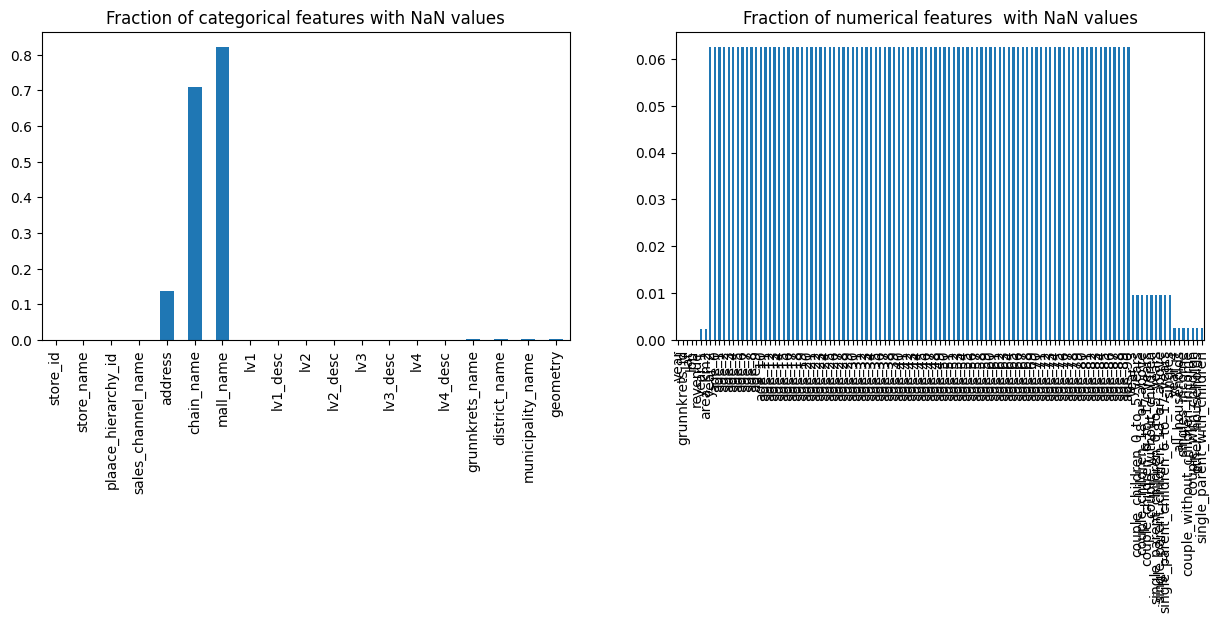

In [59]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 4), ncols=2)

df_train[categorical_features].isna().mean().plot.bar(ax=ax1)
ax1.set_title('Fraction of categorical features with NaN values')

df_train[numerical_features].isna().mean().plot.bar(ax=ax2)
ax2.set_title('Fraction of numerical features  with NaN values')

In [74]:
df_train['chain_name'].value_counts()

REMA FRANCHISE NORGE      273
JOKER                     164
MIX                       121
CIRCLE K DETALJIST        116
BUNNPRIS                  113
                         ... 
NORDSETH                    1
CHRISTOPHERSEN SANDNES      1
MOODS OF NORWAY             1
MODERN DESIGN               1
ØDEGAARD DAME               1
Name: chain_name, Length: 306, dtype: int64

In [75]:
df_train['mall_name'].value_counts()

Strømmen Storsenter    39
Amfi Moa               26
Sandvika Storsenter    26
Kvadrat                21
Ski Storsenter         20
                       ..
Løkketangen Torv        1
Lande Senter            1
Kvelde Senter           1
Kaspergården            1
Øysenteret              1
Name: mall_name, Length: 487, dtype: int64

In [76]:
df_train['store_name'].value_counts()

FRISØRLOFTET AS              2
BELLO BY BOUTIQUE BELLO      2
THINK HAIR WEAR GALLERIET    2
JAFS OSLO                    2
CAPONE KVADRAT               2
                            ..
GRAN HUDPLEIEKLINIKK AS      1
GRAN OPTIKK                  1
GRAND APARTMENT              1
GRAND BUFFE                  1
ØYVIND BJØRLO                1
Name: store_name, Length: 12829, dtype: int64

## 2.2 HeatMaps

In this section I investigate which numerical features are mostly correlated with the revenues of stores, so that I can preform some feature enginering based on that. I find that there is slight correlation between the household ages, incomes and types hence I decide to include these features in the training dataframe. This does increase the dimentionality of the set, hence if this becomes a problem due to the curse of dimentionality, I plan on using PCA (Principal Component Analysis) to reduce the dimentions.

<AxesSubplot: >

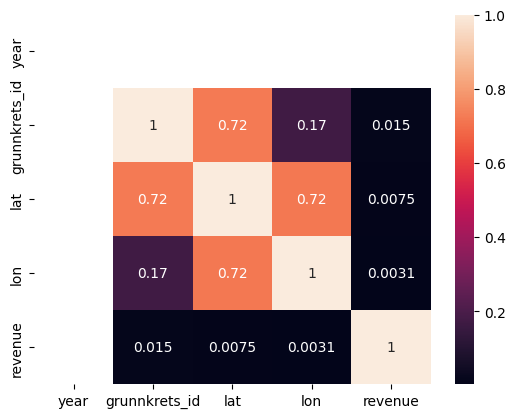

In [92]:
sns.heatmap(stores_train.corr(), annot=True)

<AxesSubplot: >

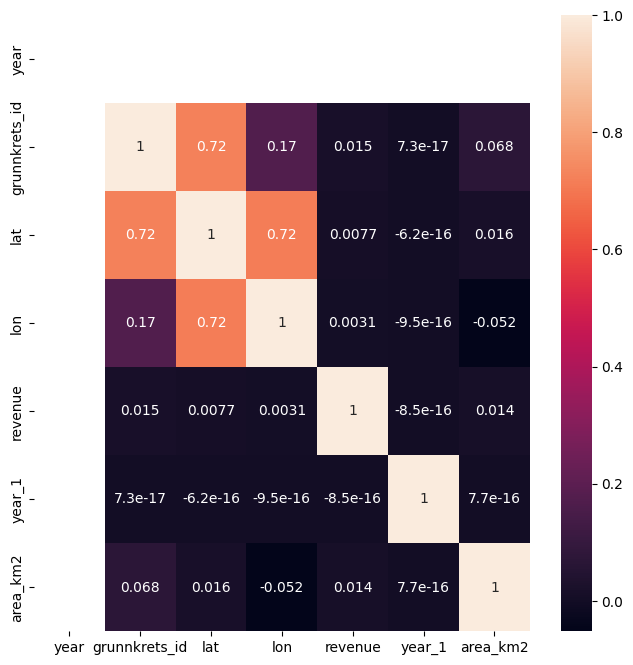

In [103]:
fig, ax = plt.subplots(figsize=(8, 8))
df_grunnkrets= pd.merge(stores_train, grunnkrets, on='grunnkrets_id', how='left')
sns.heatmap(df_grunnkrets.corr(), annot=True)

<AxesSubplot: >

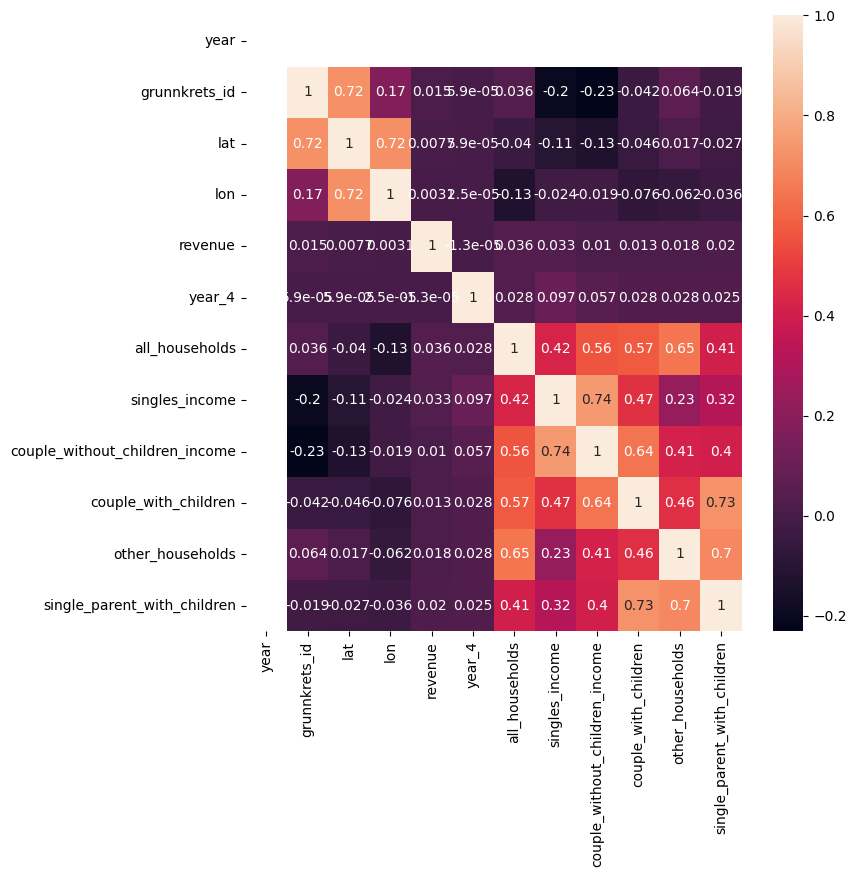

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))
df_income = pd.merge(stores_train, grunnkrets_household_income, on='grunnkrets_id', how='left')
sns.heatmap(df_income.corr(), annot=True)

<AxesSubplot: >

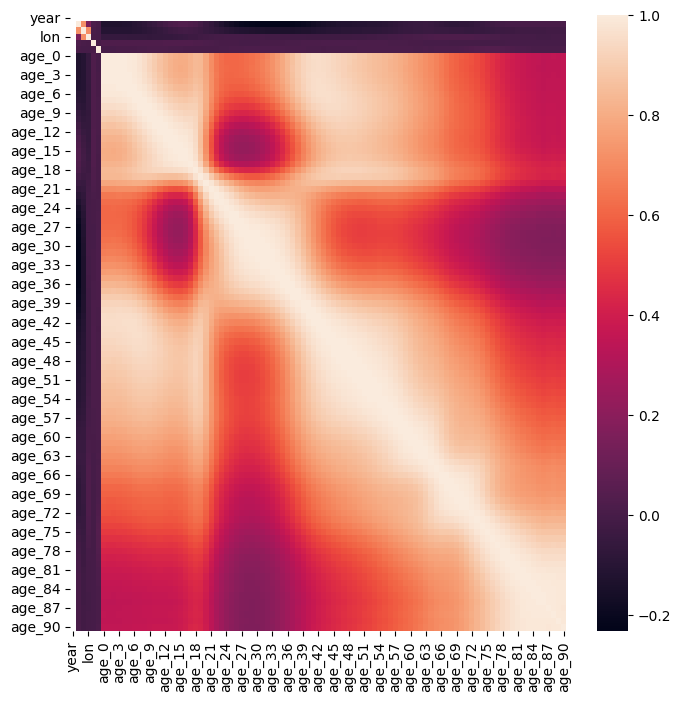

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
df_ages = pd.merge(stores_train, grunnkrets_ages, on='grunnkrets_id', how='left')
sns.heatmap(df_ages.corr())

<AxesSubplot: >

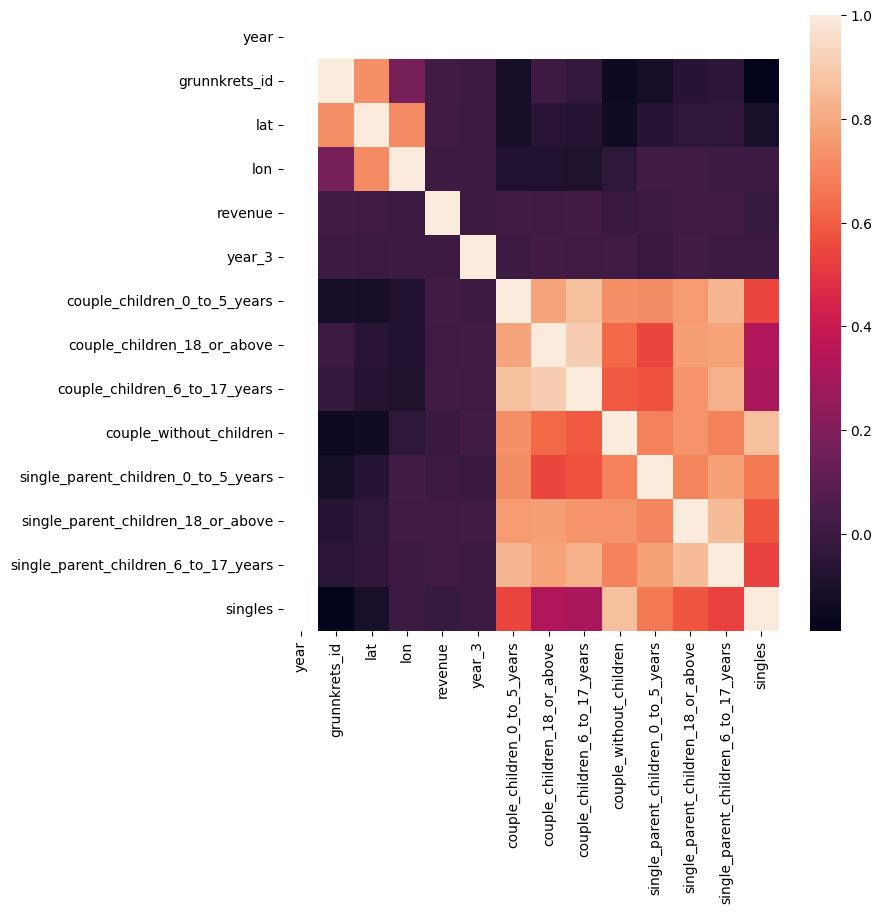

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))
df_household = pd.merge(stores_train, grunnkrets_household_types, on='grunnkrets_id', how='left')
sns.heatmap(df_household.corr())

## 2.3 Feature distribution

I check for the distributions of each feature to see if they could be scaled or normalized, and whether the outliers should be removed. I find that the revenues vissually seem to be log normally distributed, hence it makes sense to take the log of the revenues to achieve a closer to normal distribution of revenues when training the model on the data. Then I can upscale the revenue predictions by taking the exponent. I take the log(revenue + 1) so that all the logged revenues are positive, then I will later upscale the predictions with e^(predicted_values) - 1. I find that features of grunnkrets household types and ages also seem to be lognormally distributed, hence it would make taking log of them, while the features of grunnkrets incomes is more normaly distributed.

<AxesSubplot: >

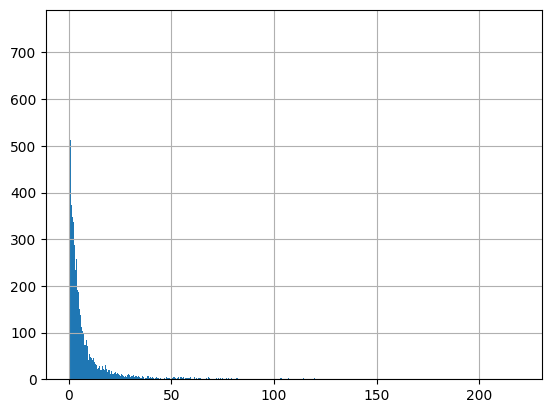

In [126]:
# revenue distribution
df_train['revenue'].hist(bins=1000)

<AxesSubplot: >

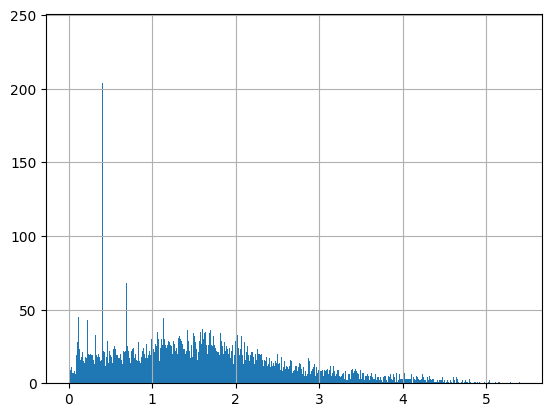

In [128]:
# log revenue distribution
log_rev = np.log1p(df_train['revenue'])
log_rev.hist(bins=1000)

<AxesSubplot: >

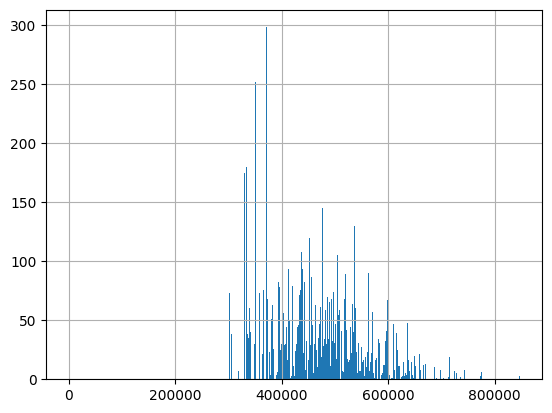

In [129]:
# distribution of incomes
df_train['all_households'].hist(bins=1000)

<AxesSubplot: >

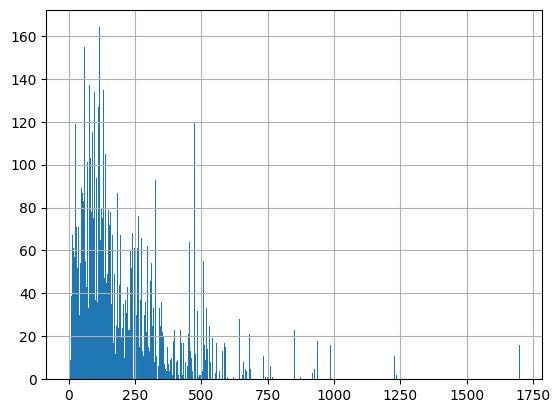

In [130]:
# household types distribution
df_train['singles'].hist(bins=1000)

<AxesSubplot: >

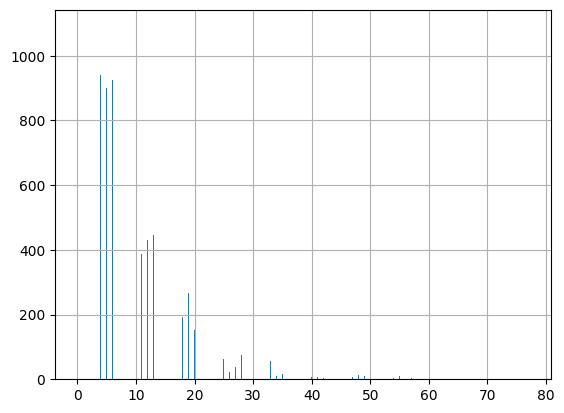

In [132]:
# distribution of ages

df_train['age_20'].hist(bins=1000)

# 3. Feature Engineering

I select the features based on the gini index based on feature importance using Gini Index. For feature engineering I derive the following new features for each of the stores in the data set:

- Distance to 5 highly populated cities in Norway: Olso, Bergen, Trondheim, Stavanger, Drammen
    - Use the lat and lon values of each city to compute the distance, max 10 constants as mentioned on blackboard
- Distance to closest busstops
- Number of busstops within a given radius r in meters.
    - The selected values for r are: 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000.
- Distance to closest lv1, lv2, lv3, lv4 stores.
- Number of lv1, lv2, lv3, lv4 within a given radius r in meters.
    - The selected values for r are: 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000.
- Population density for each grunnkrets.

## 3.1 Distance to cities

In [ ]:
oslo_lat = 59.9138688
oslo_lon = 10.7522454
bergen_lat = 60.391263
bergen_lon = 5.322054
trondheim_lat = 63.430515
trondheim_lon = 10.395053
stavanger_lat = 58.969976
stavanger_lon = 5.733107
drammen_lat = 59.742043
drammen_lon = 10.204421


from haversine import haversine, Unit

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# calculate the distance to the cities

def distance_to_city(lat, lon, city_lat, city_lon):
    
    # set 
    distance = haversine((lat, lon), (city_lat, city_lon), unit=Unit.KILOMETERS)
        
    return distance

stores_train['distance_to_oslo'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], oslo_lat, oslo_lon), axis=1)
stores_test['distance_to_oslo'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], oslo_lat, oslo_lon), axis=1)

stores_train[['store_id', 'distance_to_oslo']].to_csv('data/other_data/stores_train_distance_to_oslo.csv', index=False)
stores_test[['store_id', 'distance_to_oslo']].to_csv('data/other_data/stores_test_distance_to_oslo.csv', index=False)

stores_train['distance_to_bergen'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], bergen_lat, bergen_lon), axis=1)
stores_test['distance_to_bergen'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], bergen_lat, bergen_lon), axis=1)

stores_train[['store_id', 'distance_to_bergen']].to_csv('data/other_data/stores_train_distance_to_bergen.csv', index=False)
stores_test[['store_id', 'distance_to_bergen']].to_csv('data/other_data/stores_test_distance_to_bergen.csv', index=False)

# generate distances to Trondheim for stores_train and stores_test

stores_train['distance_to_trondheim'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], trondheim_lat, trondheim_lon), axis=1)
stores_test['distance_to_trondheim'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], trondheim_lat, trondheim_lon), axis=1)

stores_train[['store_id', 'distance_to_trondheim']].to_csv('data/other_data/stores_train_distance_to_trondheim.csv', index=False)
stores_test[['store_id', 'distance_to_trondheim']].to_csv('data/other_data/stores_test_distance_to_trondheim.csv', index=False)

stores_train['distance_to_stavanger'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], stavanger_lat, stavanger_lon), axis=1)
stores_test['distance_to_stavanger'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], stavanger_lat, stavanger_lon), axis=1)

stores_train[['store_id', 'distance_to_stavanger']].to_csv('data/other_data/stores_train_distance_to_stavanger.csv', index=False)
stores_test[['store_id', 'distance_to_stavanger']].to_csv('data/other_data/stores_test_distance_to_stavanger.csv', index=False)

stores_train['distance_to_drammen'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], drammen_lat, drammen_lon), axis=1)
stores_test['distance_to_drammen'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], drammen_lat, drammen_lon), axis=1)

stores_train[['store_id', 'distance_to_drammen']].to_csv('data/other_data/stores_train_distance_to_drammen.csv', index=False)
stores_test[['store_id', 'distance_to_drammen']].to_csv('data/other_data/stores_test_distance_to_drammen.csv', index = False)

## 3.2 Distance and Number of Busstops

In [ ]:
def find_shortest_distance_to_busstop(lat, lon):
    distances = busstops.apply(lambda x: haversine((lat, lon), (x['busstop_lat'], x['busstop_lon']), unit=Unit.METERS), axis=1)
    return distances.min()

def count_closest_busstops( lat, lon, radius):
    distances = busstops.apply(lambda x: haversine((lat, lon), (x['busstop_lat'], x['busstop_lon']), unit=Unit.METERS), axis=1)
    return len(distances[distances < radius] > 0)

stores_train['distance_to_closest_busstop'] = stores_train.apply(lambda x: find_shortest_distance_to_busstop(x['lat'], x['lon']), axis=1)
stores_test['distance_to_closest_busstop'] = stores_test.apply(lambda x: find_shortest_distance_to_busstop(x['lat'], x['lon']), axis=1)

stores_train[['store_id', 'distance_to_closest_busstop']].to_csv('data/other_data/stores_train_distance_to_closest_busstop.csv', index=False)
stores_test[['store_id', 'distance_to_closest_busstop']].to_csv('data/other_data/stores_test_distance_to_closest_busstop.csv', index=False)

radius_list = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

for radius in radius_list:

    stores_train[f'num_closest_busstops_{radius}m'] = stores_train.apply(lambda x: count_closest_busstops(x['lat'], x['lon'], radius), axis=1)
    stores_test[f'num_closest_busstops_{radius}m'] = stores_test.apply(lambda x: count_closest_busstops(x['lat'], x['lon'], radius), axis=1)

    stores_train[['store_id', f'num_closest_busstops_{radius}m']].to_csv(f'stores_train_num_closest_busstops_{radius}m.csv', index=False)
    stores_test[['store_id', f'num_closest_busstops_{radius}m']].to_csv(f'stores_test_num_closest_busstops_{radius}m.csv', index=False)

## 3.3 Distance and Number of Stores

In [ ]:
df = stores_train.copy()

df= pd.merge(df, plaace_hierarchy, how='left', on='plaace_hierarchy_id')

df.drop(columns=['revenue'], inplace=True)

df_test = stores_test.copy()

df_test = pd.merge(df_test, plaace_hierarchy, how='left', on='plaace_hierarchy_id')

stores_extra = pd.merge(stores_extra, plaace_hierarchy, how='left', on='plaace_hierarchy_id')

df = pd.concat([df_train, df_test, stores_extra], ignore_index=True)


def find_closest_store(lat, lon, lv1, col):
    distances = df[df[col] == lv1].apply(lambda x: haversine((lat, lon), (x['lat'], x['lon']), unit=Unit.METERS), axis=1)
    # can't be the store it self
    return distances[distances > 0].min()

def count_closest_stores(lat, lon, lv, col, radius):
    distances = df[df[col] == lv].apply(lambda x: haversine((lat, lon), (x['lat'], x['lon']), unit=Unit.METERS), axis=1)
    return len(distances[distances < radius] > 0)

levels = ['lv1', 'lv2', 'lv3', 'lv4']
radius_list = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

for level in levels:
    df_train[f'closest_store_{level}'] = df_train.apply(lambda x: find_closest_store(x['lat'], x['lon'], x[f'{level}_desc'], level), axis=1)
    df_test[f'closest_store_{level}'] = df_test.apply(lambda x: find_closest_store(x['lat'], x['lon'], x[f'{level}_desc'], level), axis=1)
    
    df_train[['store_id', f'closest_store_{level}']].to_csv(f'stores_train_closest_store_{level}.csv', index=False)
    df_test[['store_id', f'closest_store_{level}']].to_csv(f'stores_test_closest_store_{level}.csv', index=False)
    
    for radius in radius_list:
        df_train[f'num_closest_stores_{level}_{radius}m'] = df_train.apply(lambda x: count_closest_stores(x['lat'], x['lon'], x[f'{level}_desc'], level, radius), axis=1)
        df_test[f'num_closest_stores_{level}_{radius}m'] = df_test.apply(lambda x: count_closest_stores(x['lat'], x['lon'], x[f'{level}_desc'], level, radius), axis=1)

        df_train[['store_id',f'num_closest_stores_lv1_{radius}m']].to_csv(f'stores_train_num_closest_stores_{level}_{radius}.csv', index=False)
        df_test[['store_id',f'num_closest_stores_lv1_{radius}m']].to_csv(f'stores_test_num_closest_stores_{level}_{radius}m.csv', index=False)

## 3.4 Grunnkrets Population Density 

In [143]:
df_train['grunnkrets_population_density'] = df_train['grunnkrets_population'] / df_train['area_km2']

## 3.5 Feature Selection

I test combination of different features of the dataset and decide to drop the features selected below to optimize the preformace of the predictor, based on the gini index. 



In [144]:
columns_to_drop = ['revenue', 'store_id', 'plaace_hierarchy_id', 'grunnkrets_id', 'year', 'address',
                   'store_name', 'year_1', 'geometry', 'grunnkrets_name', 'district_name', 'municipality_name',
                   'year_2', 'year_3', 'year_4', 'sales_channel_name', 'lv1', 'lv2', 'lv3', 'lv4']

# 4. Model Interpratation

## 4.1 Gini Index
Below is an example of how I selected which features to proceed with and which features to drop based on the Gini Index on LGBM Regressor.

In [146]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

def convert_to_category(X):
    for col in X.columns:
        if ( (X[col].dtype != 'int64') and (X[col].dtype != 'float64') and (X[col].dtype != 'bool')):
            X[col] = X[col].astype('category')
    return X

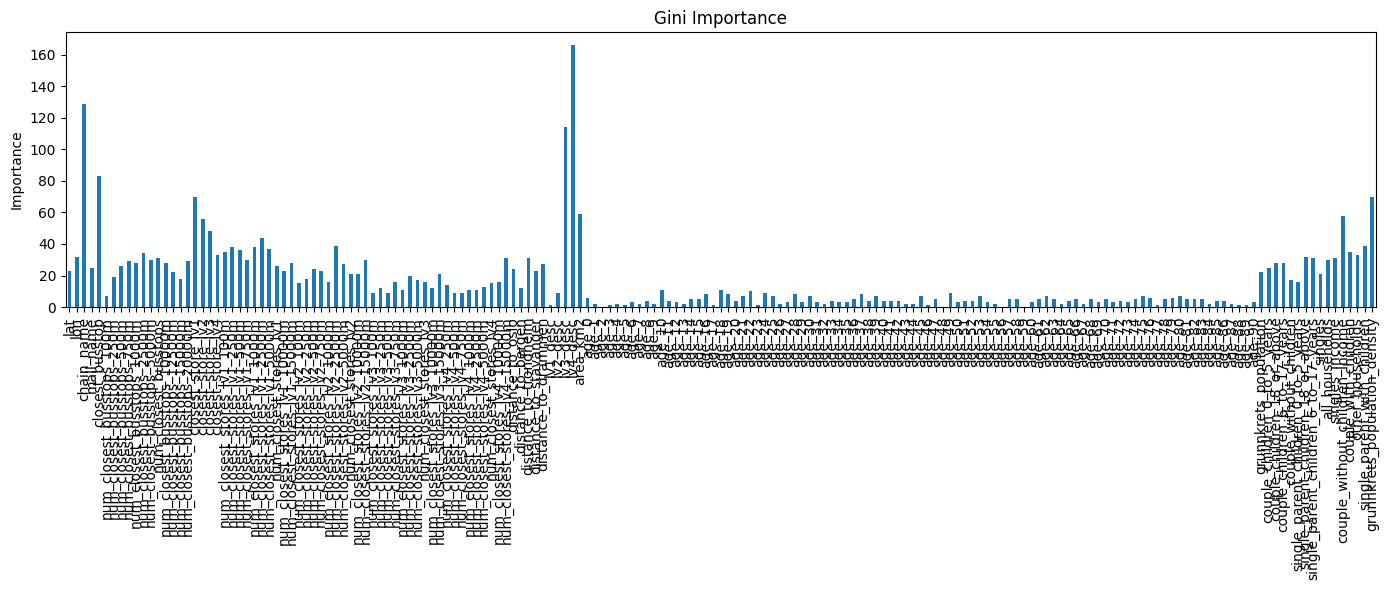

In [169]:
stores_train = pd.read_csv('data/stores_train_with_extra_features.csv')
stores_test = pd.read_csv('data/stores_test_with_extra_features.csv')

df = stores_train

df = pd.merge(df, plaace_hierarchy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income, on='grunnkrets_id', how='left')

df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

df['grunnkrets_population_density'] = df['grunnkrets_population'] / df['area_km2']

X = df.drop(columns=columns_to_drop)
X = convert_to_category(X)

y = df.revenue
y = np.log1p(y)

categorical_features = X.select_dtypes(include=['category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

lgbm_model = lgbm.LGBMRegressor()


kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        
    lgbm_model.fit(X_train, y_train)

    y_train_pred_lgbm = lgbm_model.predict(X_train)
    y_val_pred_lgbm = lgbm_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_lgbm = np.expm1(y_train_pred_lgbm)
    y_val_pred_lgbm = np.expm1(y_val_pred_lgbm)
    y_train_pred_lgbm[y_train_pred_lgbm < 0] = 0
    y_val_pred_lgbm[y_val_pred_lgbm < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_lgbm)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_lgbm)


importances = lgbm_model.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

## 4.2 K-Fold Cross Validation
The example below shows that I use K-fold cross validation on the when training the models to ensure that the train and validation score varies less and is the more reliable.

In [170]:
lgbm_model = lgbm.LGBMRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        
    lgbm_model.fit(X_train, y_train)

    y_train_pred_lgbm = lgbm_model.predict(X_train)
    y_val_pred_lgbm = lgbm_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_lgbm = np.expm1(y_train_pred_lgbm)
    y_val_pred_lgbm = np.expm1(y_val_pred_lgbm)
    y_train_pred_lgbm[y_train_pred_lgbm < 0] = 0
    y_val_pred_lgbm[y_val_pred_lgbm < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_lgbm)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_lgbm)


print(f'Train set LGBM RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set LGBM RMSLE: {kf_val_scores.mean():.4f}')

Train set LGBM RMSLE: 0.5639
Validation set LGBM RMSLE: 0.7379


# 5 Preditors/Models

I explore the four following models/predictors for this project, which are:
- LGBM
- XGBoost
- CatBoost
- H2O AutoML
I find that an ensemble with average score of predictions from LGBM and Catboost preforms quite well, but the H2O AutoML predictor preforms even better.

## 5.1 LGBM

In [171]:
# selected params for optimal preformance, tuned using Optuna
params_lgbm_experimental = {'n_estimators': 366,
 'reg_alpha': 0.046433293427957184,
 'reg_lambda': 7.3647658153160185,
 'colsample_bytree': 0.7504777271414033,
 'subsample': 0.21125558206697211,
 'learning_rate': 0.017734794109992907,
 'max_depth': 31,
 'num_leaves': 29,
 'min_child_samples': 197}



lgbm_model = lgbm.LGBMRegressor(
                            **params_lgbm_experimental,
                               )

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        
    lgbm_model.fit(X_train, y_train)

    y_train_pred_lgbm = lgbm_model.predict(X_train)
    y_val_pred_lgbm = lgbm_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_lgbm = np.expm1(y_train_pred_lgbm)
    y_val_pred_lgbm = np.expm1(y_val_pred_lgbm)
    y_train_pred_lgbm[y_train_pred_lgbm < 0] = 0
    y_val_pred_lgbm[y_val_pred_lgbm < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_lgbm)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_lgbm)


print(f'Train set LGBM RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set LGBM RMSLE: {kf_val_scores.mean():.4f}')

Train set LGBM RMSLE: 0.6389
Validation set LGBM RMSLE: 0.7320


## 5.2 XGBoost
Since XGBoost and CatBoost doesn't take in categorical variable, I one hot encode then. This increase the dimentinality of the training dataframe by lot, however the xgboost and catboost preforms quite well even on the higher dimentionality frame.

In [172]:
# One hot encoding
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
one_hot_encoder = full_pipeline.fit(X)
X_encoded_one_hot = one_hot_encoder.transform(X)

In [173]:
random_state = 12

X_selected = X_encoded_one_hot.copy()
y_selected = y.copy()

# selected params for optimal preformance, tuned using Optuna
params_xgb= {
 'max_depth': 4,
 'learning_rate': 0.028362027029429517,
 'n_estimators': 2000,
 'min_child_weight': 4,
 'gamma': 0.0005280660397836893,
 'subsample': 0.9591571400658773,
 'colsample_bytree': 0.15020047099017486,
 'reg_alpha': 0.005239018274302711,
 'reg_lambda': 0.3543952455437745
 }


xgboost_model = xgb.XGBRegressor(
                                 **params_xgb,
                                 )

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X_selected, y_selected)):
    X_train, X_val = X_selected[train_index], X_selected[test_index]
    y_train, y_val = y_selected.iloc[train_index], y_selected.iloc[test_index]
    
    
    xgboost_model.fit(X_train, y_train)

    y_train_pred_xgb = xgboost_model.predict(X_train)
    y_val_pred_xgb = xgboost_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_xgb = np.expm1(y_train_pred_xgb)
    y_val_pred_xgb = np.expm1(y_val_pred_xgb)
    y_train_pred_xgb[y_train_pred_xgb < 0] = 0
    y_val_pred_xgb[y_val_pred_xgb < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_xgb)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_xgb)


print(f'Train set XGBoost RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set XGBoost RMSLE: {kf_val_scores.mean():.4f}')

Train set XGBoost RMSLE: 0.5580
Validation set XGBoost RMSLE: 0.7261


## 5.3 CatBoost

In [174]:
X_selected = X_encoded_one_hot.copy()
y_selected = y.copy()

cat_boost_model = cat.CatBoostRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X_selected, y_selected)):
 
    X_train, X_val = X_selected[train_index], X_selected[test_index]
    y_train, y_val = y.iloc[train_index], y_selected.iloc[test_index]
    
   
    
    cat_boost_model.fit(X_train, y_train)

    y_train_pred_cat = cat_boost_model.predict(X_train)
    y_val_pred_cat = cat_boost_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_cat = np.expm1(y_train_pred_cat)
    y_val_pred_cat = np.expm1(y_val_pred_cat)
    y_train_pred_cat[y_train_pred_cat < 0] = 0
    y_val_pred_cat[y_val_pred_cat < 0] = 0

    kf_train_scores[idx] = rmsle(y_train, y_train_pred_cat)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_cat)
    
print(f'Train set CatBoost RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set CatBoost RMSLE: {kf_val_scores.mean():.4f}')

Learning rate set to 0.059173
0:	learn: 1.0040476	total: 8.43ms	remaining: 8.42s
1:	learn: 0.9855011	total: 16.4ms	remaining: 8.18s
2:	learn: 0.9668052	total: 25.2ms	remaining: 8.37s
3:	learn: 0.9503509	total: 33.3ms	remaining: 8.3s
4:	learn: 0.9350564	total: 42.2ms	remaining: 8.39s
5:	learn: 0.9209240	total: 49.9ms	remaining: 8.26s
6:	learn: 0.9085816	total: 57.8ms	remaining: 8.19s
7:	learn: 0.8973603	total: 65.9ms	remaining: 8.17s
8:	learn: 0.8870766	total: 74.1ms	remaining: 8.16s
9:	learn: 0.8788085	total: 82.9ms	remaining: 8.21s
10:	learn: 0.8703039	total: 90.7ms	remaining: 8.15s
11:	learn: 0.8628057	total: 98.4ms	remaining: 8.1s
12:	learn: 0.8562059	total: 106ms	remaining: 8.06s
13:	learn: 0.8493973	total: 114ms	remaining: 8.03s
14:	learn: 0.8432343	total: 122ms	remaining: 7.99s
15:	learn: 0.8379228	total: 130ms	remaining: 8.01s
16:	learn: 0.8334925	total: 139ms	remaining: 8.01s
17:	learn: 0.8287191	total: 146ms	remaining: 7.97s
18:	learn: 0.8249312	total: 154ms	remaining: 7.97s
1

## 5.4 AutoML

In [179]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 mins 16 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_levit_fgfmpc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.831 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [180]:
X_new = pd.concat([X, y], axis=1)


train = h2o.H2OFrame(X_new)

x_columns = train.columns
y_columns = "revenue"
x_columns.remove(y_columns)

aml = H2OAutoML(max_models=3, seed=1, sort_metric='RMSE')
aml.train(x=x_columns, y=y_columns, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
17:09:54.12: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.5434942,0.0080851,0.5534634,0.5481815,0.5325975,0.5442891,0.5389394
mean_residual_deviance,0.5157238,0.0127299,0.5361894,0.5191039,0.5054638,0.5121236,0.5057383
mse,0.5157238,0.0127299,0.5361894,0.5191039,0.5054638,0.5121236,0.5057383
null_deviance,2702.3442,168.41205,2885.8584,2727.3994,2684.9795,2780.759,2432.7244
r2,0.5079375,0.0127660,0.5128261,0.5077459,0.5049509,0.5246546,0.4895100
residual_deviance,1326.6912,60.005543,1405.8884,1342.4028,1325.3262,1321.791,1238.0474
rmse,0.7180958,0.0088214,0.7322495,0.7204887,0.7109598,0.7156281,0.7111528
rmsle,0.3133841,0.0072587,nan,0.3212437,0.3038753,0.3127060,0.3157113


# 6. Prediction and Further Model Interpreation

In [182]:
colums_to_drop = columns_to_drop[1:]
stores_test_copy = stores_test.copy()

df = stores_test_copy

df = pd.merge(df, plaace_hierarchy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income, on='grunnkrets_id', how='left')

df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df['grunnkrets_population_density'] = df['grunnkrets_population'] / df['area_km2']

X_test = df.drop(columns = colums_to_drop)
X_test = convert_to_category(X_test)

X_test_encoded_one_hot = one_hot_encoder.transform(X_test)



y_test_pred = 0
n = 0

X_test_selected = X_test_encoded_one_hot.copy()


y_test_pred_lgbm = lgbm_model.predict(X_test)
y_test_pred_lgbm = np.expm1(y_test_pred_lgbm)
y_test_pred_lgbm = np.where(y_test_pred_lgbm < 0, 0, y_test_pred_lgbm)

y_test_pred += y_test_pred_lgbm
n+=1


y_test_pred_xgb = xgboost_model.predict(X_test_selected)
y_test_pred_xgb = np.expm1(y_test_pred_xgb)
y_test_pred_xgb = np.where(y_test_pred_xgb < 0, 0, y_test_pred_xgb)

# y_test_pred += y_test_pred_xgb
# n+=1


y_test_pred_cat = cat_boost_model.predict(X_test_selected)
y_test_pred_cat = np.expm1(y_test_pred_cat)
y_test_pred_cat = np.where(y_test_pred_cat < 0, 0, y_test_pred_cat)

# y_test_pred += y_test_pred_cat
# n+=1

# y_test_pred_h2o = aml.leader.predict(h2o.H2OFrame(X_test_selected))
# y_test_pred_h2o = np.expm1(y_test_pred_h2o.as_data_frame())
# y_test_pred_h2o = np.where(y_test_pred_h2o < 0, 0, y_test_pred_h2o)

# y_test_pred = y_test_pred_h2o
# n+=1



# stacking one boosting method 

y_test_pred = y_test_pred/n

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test['store_id']
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submissions/sample_submission.csv', index=False)
submission


,id,predicted
0,914206820-914239427-717245,6.075487
1,916789157-916823770-824309,6.662607
2,913341082-977479363-2948,4.919315
3,889682582-889697172-28720,9.839216
4,997991699-998006945-417222,5.343715
...,...,...
8572,917323003-917383529-844309,1.727969
8573,917353379-917411824-845904,2.706240
8574,917072302-917089248-833647,2.554141
8575,916960557-916993161-829908,1.807110


## 6.2 LGBM vs XGBoost

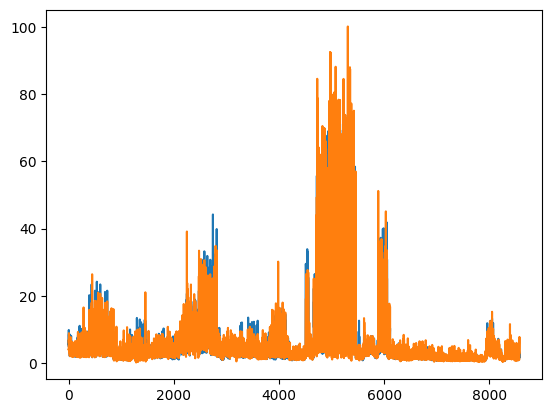

In [183]:
plt.plot(y_test_pred_lgbm)
plt.plot(y_test_pred_xgb)

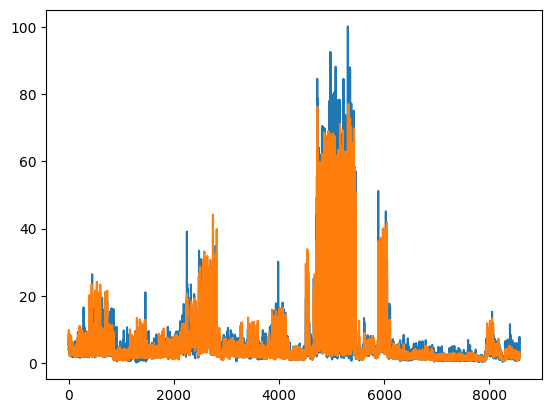

In [184]:
plt.plot(y_test_pred_xgb)
plt.plot(y_test_pred_lgbm)


## 6.3 LGBM vs Catboost

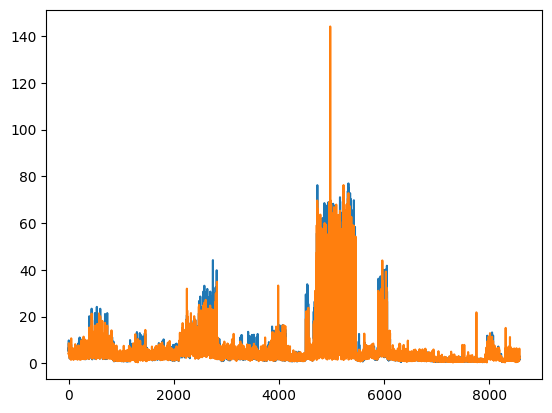

In [185]:
plt.plot(y_test_pred_lgbm)
plt.plot(y_test_pred_cat)

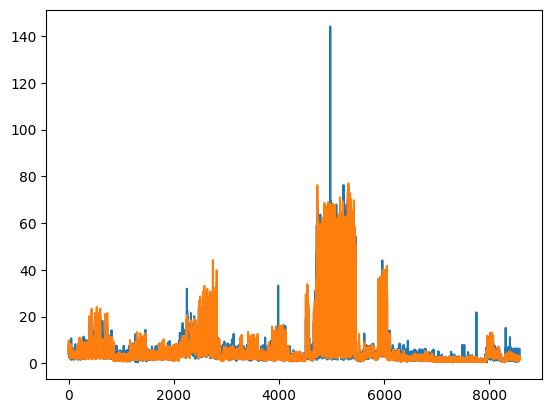

In [186]:
plt.plot(y_test_pred_cat)
plt.plot(y_test_pred_lgbm)

In [188]:
rmsle_lgbm_xgb = rmsle(y_test_pred_lgbm, y_test_pred_xgb)
rmsle_lgbm_cat = rmsle(y_test_pred_lgbm, y_test_pred_cat)
rmsle_xgb_cat = rmsle(y_test_pred_xgb, y_test_pred_cat)

print(f'RMSLE lgbm xgb: {rmsle_lgbm_xgb :.4f}')
print(f'RMSLE lgbm cat: {rmsle_lgbm_cat :.4f}')
print(f'RMSLE xgb cat: {rmsle_xgb_cat :.4f}')

RMSLE lgbm xgb: 0.2178
RMSLE lgbm cat: 0.2276
RMSLE xgb cat: 0.1416
